In [0]:
import numpy as np
import pandas as pd
import gzip 
import random
import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Install PyDrive and import relevant modules (no need to run twice)
!pip install PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client (follow the instruction as followed)
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Get the file train.gz
downloaded = drive.CreateFile({'id':"12_xwryWPFZBnHIUPABQNWCYwY3GEpmeP"})   # replace the id with id of file you want to access
downloaded.GetContentFile('train.gz') 
# Get the file test.gz
downloaded = drive.CreateFile({'id':"196Qb40QHHOrGdk7m1c5DKXY1EIu7DX8R"})   # replace the id with id of file you want to access
downloaded.GetContentFile('test.gz') 

In [0]:
# Set up sampling parameters and define data types
n = 40428967  #total number of records in the clickstream data 
sample_size = 1000000
skip_values = sorted(random.sample(range(1,n), n-sample_size)) 

types_train = {
    'id': np.dtype(str),
    'click': np.dtype(int),
    'hour': np.dtype(int),
    'C1': np.dtype(int),
    'banner_pos': np.dtype(int),
    'site_id': np.dtype(str),
    'site_domain': np.dtype(str), 
    'site_category': np.dtype(str),
    'app_id': np.dtype(str),
    'app_domain': np.dtype(str),
    'app_category': np.dtype(str),
    'device_id': np.dtype(str),
    'device_ip': np.dtype(str),
    'device_model': np.dtype(str),
    'device_type': np.dtype(int),
    'device_conn_type': np.dtype(int),
    'C14': np.dtype(int),
    'C15': np.dtype(int),
    'C16': np.dtype(int),
    'C17': np.dtype(int),
    'C18': np.dtype(int),
    'C19': np.dtype(int),
    'C20': np.dtype(int),
    'C21':np.dtype(int)
}
types_test = {
    'id': np.dtype(str),
    'hour': np.dtype(int),
    'C1': np.dtype(int),
    'banner_pos': np.dtype(int),
    'site_id': np.dtype(str),
    'site_domain': np.dtype(str), 
    'site_category': np.dtype(str),
    'app_id': np.dtype(str),
    'app_domain': np.dtype(str),
    'app_category': np.dtype(str),
    'device_id': np.dtype(str),
    'device_ip': np.dtype(str),
    'device_model': np.dtype(str),
    'device_type': np.dtype(int),
    'device_conn_type': np.dtype(int),
    'C14': np.dtype(int),
    'C15': np.dtype(int),
    'C16': np.dtype(int),
    'C17': np.dtype(int),
    'C18': np.dtype(int),
    'C19': np.dtype(int),
    'C20': np.dtype(int),
    'C21':np.dtype(int)
}

In [0]:
# Read train.gz data
parse_date = lambda val : pd.datetime.strptime(val, '%y%m%d%H')
with gzip.open('train.gz') as f:
    train = pd.read_csv(f, parse_dates = ['hour'], date_parser = parse_date, dtype=types_train, skiprows = skip_values)
    train.head()

NameError: ignored

In [0]:
train.shape

(1000000, 28)

In [0]:
train.dtypes

id                                object
click                              int64
hour                      datetime64[ns]
banner_pos                         int64
device_id                         object
device_ip                         object
device_model                      object
device_type                        int64
device_conn_type                   int64
C1                                 int64
C14                                int64
C15                                int64
C16                                int64
C17                                int64
C18                                int64
C19                                int64
C20                                int64
C21                                int64
hour_of_day                        int64
day_of_week                       object
pub_id                            object
pub_domain                        object
pub_category                      object
device_id_count                    int64
device_ip_count 

In [0]:
train['click'].value_counts()

0    830545
1    169455
Name: click, dtype: int64

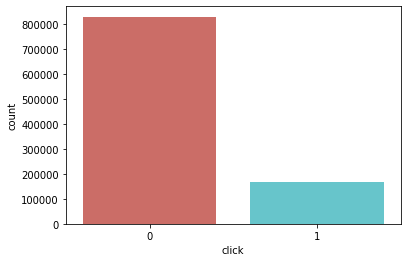

In [0]:
sns.countplot(x='click',data=train, palette='hls')
plt.show();

In [0]:
train['click'].value_counts()/len(train)

0    0.830094
1    0.169906
Name: click, dtype: float64

In [0]:
train.hour.describe()

count                 1000000
unique                    240
top       2014-10-22 09:00:00
freq                    11045
first     2014-10-21 00:00:00
last      2014-10-30 23:00:00
Name: hour, dtype: object

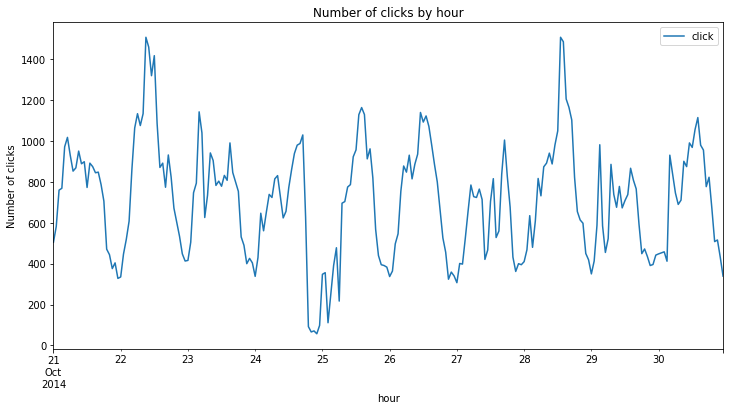

In [0]:
train.groupby('hour').agg({'click':'sum'}).plot(figsize=(12,6))
plt.ylabel('Number of clicks')
plt.title('Number of clicks by hour');

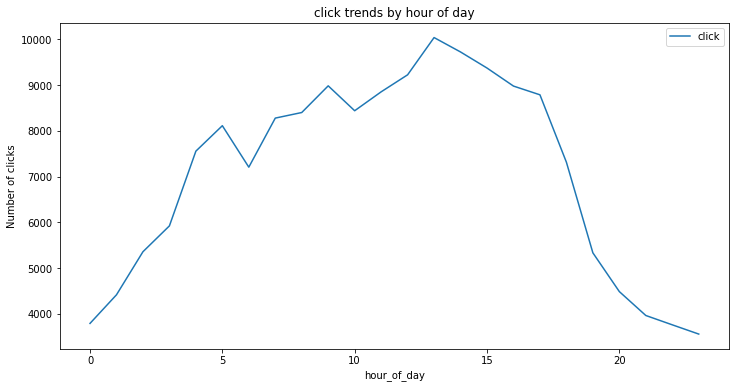

In [0]:
train['hour_of_day'] = train.hour.apply(lambda x: x.hour)
train.groupby('hour_of_day').agg({'click':'sum'}).plot(figsize=(12,6))
plt.ylabel('Number of clicks')
plt.title('click trends by hour of day');

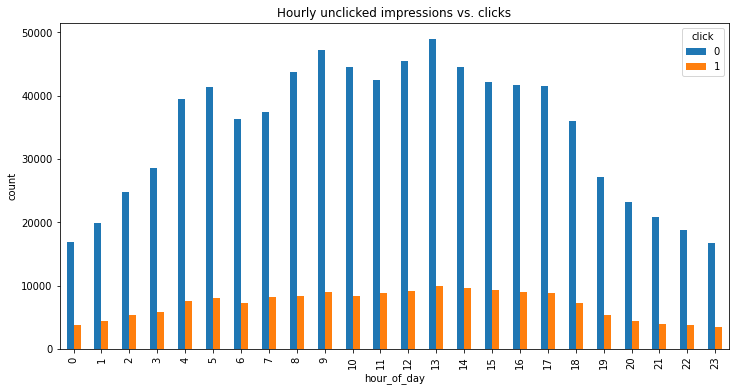

In [0]:
train.groupby(['hour_of_day', 'click']).size().unstack().plot(kind='bar', title="Hour of Day", figsize=(12,6))
plt.ylabel('count')
plt.title('Hourly unclicked impressions vs. clicks');

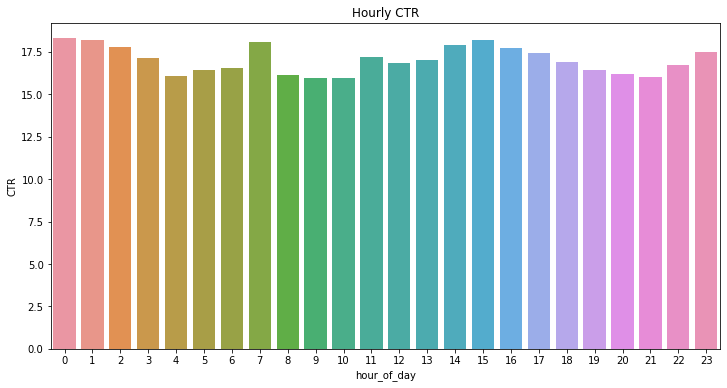

In [0]:
df_click = train[train['click'] == 1]
df_hour = train[['hour_of_day','click']].groupby(['hour_of_day']).count().reset_index()
df_hour = df_hour.rename(columns={'click': 'impressions'})
df_hour['clicks'] = df_click[['hour_of_day','click']].groupby(['hour_of_day']).count().reset_index()['click']
df_hour['CTR'] = df_hour['clicks']/df_hour['impressions']*100

plt.figure(figsize=(12,6))
sns.barplot(y='CTR', x='hour_of_day', data=df_hour)
plt.title('Hourly CTR');

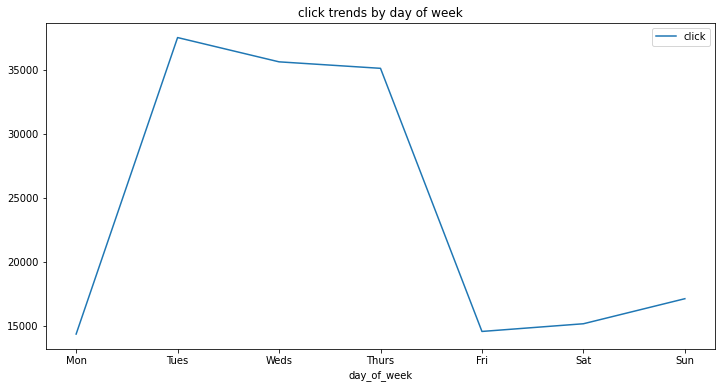

In [0]:
train['day_of_week'] = train['hour'].apply(lambda val: val.day_name())
cats = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
train.groupby('day_of_week').agg({'click':'sum'}).reindex(cats).plot(figsize=(12,6))
ticks = list(range(0, 7, 1)) # points on the x axis where you want the label to appear
labels = "Mon Tues Weds Thurs Fri Sat Sun".split()
plt.xticks(ticks, labels)
plt.title('click trends by day of week');

In [0]:
#####################.   Below is the feature engineering & new feature visualization & model training part #######################

In [0]:
# feature engineering
import collections
def scan(path):
    for i, row in enumerate(csv.DictReader(open(path)), start=1):
        if i % 1000000 == 0:
            sys.stderr.write('{0:6.0f}    {1}m\n'.format(time.time()-start,int(i/1000000)))

        user = def_user(row)
        id_cnt[row['device_id']] += 1
        ip_cnt[row['device_ip']] += 1
        user_cnt[user] += 1
        user_hour_cnt[user+'-'+row['hour']] += 1

history = collections.defaultdict(lambda: {'history': '', 'buffer': '', 'prev_hour': ''})

def def_user(row):
    
    if row['device_id'] == 'a99f214a':
        user = 'ip-' + row['device_ip'] + '-' + row['device_model']
    else:
        user = 'id-' + row['device_id']

    return user

def def_user_hour(row):
    return def_user(row) + '-' + row['hour']

def is_app(row):
    
    return True if row['site_id'] == '85f751fd' else False

def gen_data(src_path, dst_app_path, dst_site_path, is_train):
    reader = csv.DictReader(open(src_path))
    writer_app = csv.DictWriter(open(dst_app_path, 'w'), NEW_FIELDS)
    writer_site = csv.DictWriter(open(dst_site_path, 'w'), NEW_FIELDS)
    writer_app.writeheader()
    writer_site.writeheader()

    for i, row in enumerate(reader, start=1):
        if i % 1000000 == 0:
            sys.stderr.write('{0:6.0f}    {1}m\n'.format(time.time()-start,int(i/1000000)))
        
        new_row = {}
        for field in FIELDS:
            new_row[field] = row[field]

        new_row['device_id_count'] = id_cnt[row['device_id']]
        new_row['device_ip_count'] = ip_cnt[row['device_ip']]

        user, hour = def_user(row), row['hour']
        new_row['user_count'] = user_cnt[user]
        new_row['smooth_user_hour_count'] = str(user_hour_cnt[user+'-'+hour])

        if has_id_info(row):

            if history[user]['prev_hour'] != row['hour']:
                history[user]['history'] = (history[user]['history'] + history[user]['buffer'])[-4:]
                history[user]['buffer'] = ''
                history[user]['prev_hour'] = row['hour']

            new_row['user_click_histroy'] = history[user]['history']

            if is_train:
                history[user]['buffer'] += row['click']
        else:
            new_row['user_click_histroy'] = ''

        if is_app(row):
            new_row['pub_id'] = row['app_id']
            new_row['pub_domain'] = row['app_domain']
            new_row['pub_category'] = row['app_category']
            writer_app.writerow(new_row)
        else:
            new_row['pub_id'] = row['site_id']
            new_row['pub_domain'] = row['site_domain']
            new_row['pub_category'] = row['site_category']
            writer_site.writerow(new_row)

In [0]:
# Get the file data.csv after feature engineering
downloaded = drive.CreateFile({'id':"1aaozhzuv1ostOue-vs2jQ4DAlySA37Jc"})   # replace the id with id of file you want to access
downloaded.GetContentFile('data.csv') 

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
types_data = {
    'id': np.dtype(str),
    'click': np.dtype(int),
    'hour': np.dtype(int),
    'banner_pos': np.dtype(str),
    'device_id': np.dtype(str),
    'device_ip': np.dtype(str),
    'device_model': np.dtype(str),
    'device_type': np.dtype(str),
    'device_conn_type': np.dtype(str),
    'C1': np.dtype(int),
    'C14': np.dtype(int),
    'C15': np.dtype(int),
    'C16': np.dtype(int),
    'C17': np.dtype(int),
    'C18': np.dtype(int),
    'C19': np.dtype(int),
    'C20': np.dtype(int),
    'C21':np.dtype(int),
    'hour_of_day':np.dtype(str),
    'day_of_week':np.dtype(str),
    'pub_id': np.dtype(str),
    'pub_domain': np.dtype(str), 
    'pub_category': np.dtype(str),
    'device_id_count':np.dtype(int),
    'device_ip_count':np.dtype(int),
    'user_count':np.dtype(int),
    'smooth_user_hour_count':np.dtype(int),
    'user_click_history':np.dtype(str),
}

In [0]:
# Read train.csv data
parse_date = lambda val : pd.datetime.strptime(val, '%y%m%d%H')
with open('data.csv') as f:
    data = pd.read_csv(f,parse_dates = ['hour'], date_parser = parse_date, dtype=types_data)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime instead.
  """Entry point for launching an IPython kernel.


In [0]:
data.head()

,id,click,hour,banner_pos,device_id,device_ip,device_model,device_type,device_conn_type,C1,C14,C15,C16,C17,C18,C19,C20,C21,hour_of_day,day_of_week,pub_id,pub_domain,pub_category,device_id_count,device_ip_count,user_count,smooth_user_hour_count,user_click_history
0,5625844144490291740,1,2014-10-23 06:00:00,1,a99f214a,dbd54f76,6e1e2240,1,0,1005,21153,320,50,2420,2,35,100188,69,6,Thursday,57fe1b20,5b626596,f028772b,924256,1,1,1,NaN
1,6228908776273355562,1,2014-10-22 04:00:00,0,a99f214a,c00916fb,4ea23a13,1,0,1005,21725,320,50,2502,0,35,100083,221,4,Wednesday,1fbe01fe,f3845767,28905ebd,924256,38,1,1,NaN
2,13646228992635606534,1,2014-10-22 10:00:00,0,a99f214a,0489ce3f,edead9f4,1,0,1005,15703,320,50,1722,0,35,-1,79,10,Wednesday,1fbe01fe,f3845767,28905ebd,924256,1906,9,1,NaN
3,14496404417797877012,0,2014-10-29 11:00:00,1,a99f214a,6394f6f6,c3f7117b,1,0,1005,23369,320,50,2680,3,815,100156,42,11,Wednesday,ce3307ec,7e091613,f028772b,924256,2104,138,4,NaN
4,2128862029846868642,1,2014-10-26 14:00:00,0,a99f214a,d139e860,0eb711ec,1,0,1005,20108,320,50,2299,2,1327,100084,52,14,Sunday,1fbe01fe,f3845767,28905ebd,924256,4,1,1,NaN


In [0]:
data.describe()

,click,C1,C14,C15,C16,C17,C18,C19,C20,C21,device_id_count,device_ip_count,user_count,smooth_user_hour_count
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,0.169455,1004.967897,18839.741826,318.889360,60.098362,2112.435999,1.432945,226.959755,53217.607820,83.351003,762678.638068,138.408203,14.241894,1.400476
std,0.375153,1.095876,4959.775142,21.415965,47.272539,609.377917,1.326403,350.794208,49956.801943,70.242278,351042.355193,586.650360,81.546331,2.694119
min,0.000000,1001.000000,375.000000,120.000000,20.000000,112.000000,0.000000,33.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,1005.000000,16920.000000,320.000000,50.000000,1863.000000,0.000000,35.000000,-1.000000,23.000000,924256.000000,1.000000,1.000000,1.000000
50%,0.000000,1005.000000,20346.000000,320.000000,50.000000,2323.000000,2.000000,39.000000,100049.000000,61.000000,924256.000000,2.000000,1.000000,1.000000
75%,0.000000,1005.000000,21894.000000,320.000000,50.000000,2526.000000,3.000000,171.000000,100094.000000,101.000000,924256.000000,10.000000,2.000000,1.000000
max,1.000000,1012.000000,24043.000000,1024.000000,1024.000000,2757.000000,3.000000,1839.000000,100248.000000,255.000000,924256.000000,5560.000000,924.000000,161.000000


In [0]:
print(data.device_id_count.value_counts()/len(data))

924256    0.825180
1         0.135475
2         0.020805
3         0.006451
4         0.003095
5         0.001626
6         0.001008
7         0.000786
536       0.000536
525       0.000525
9         0.000513
8         0.000489
11        0.000313
324       0.000308
10        0.000268
296       0.000242
13        0.000226
12        0.000225
16        0.000222
102       0.000194
15        0.000159
20        0.000120
19        0.000110
105       0.000098
98        0.000095
99        0.000091
85        0.000085
24        0.000072
18        0.000072
23        0.000068
17        0.000061
14        0.000061
70        0.000061
30        0.000060
25        0.000048
22        0.000044
54        0.000043
40        0.000040
35        0.000035
31        0.000031
38        0.000030
29        0.000029
Name: device_id_count, dtype: float64


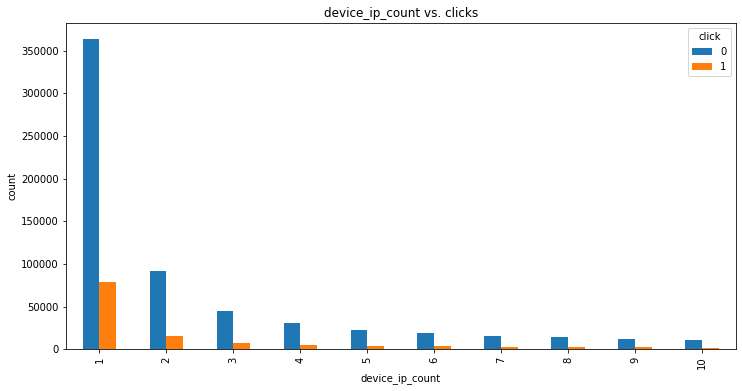

In [0]:
top10_device_ip = data[(data.device_ip_count.isin((data.device_ip_count.value_counts()/len(data))[0:10].index))]
top10_device_ip.groupby(['device_ip_count', 'click']).size().unstack().plot(kind='bar', title="Hour of Day", figsize=(12,6))
plt.ylabel('count')
plt.title('device_ip_count vs. clicks');

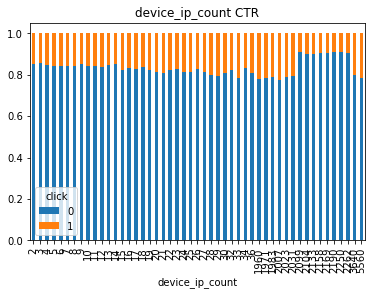

In [0]:
device_ip_count_2_11 = data[(data.device_ip_count.isin((data.device_ip_count.value_counts()/len(data))[1:50].index))]
device_ip_count_2_11 = device_ip_count_2_11.groupby(['device_ip_count','click']).size().unstack()
device_ip_count_2_11.div(device_ip_count_2_11.sum(axis=1), axis=0).plot(kind='bar', stacked=True, title="device_ip_count CTR");

In [0]:
print(data.user_count.value_counts()/len(data))

1      0.670037
2      0.125250
3      0.048384
4      0.025160
5      0.015222
         ...   
114    0.000093
118    0.000093
91     0.000090
101    0.000086
117    0.000075
Name: user_count, Length: 188, dtype: float64


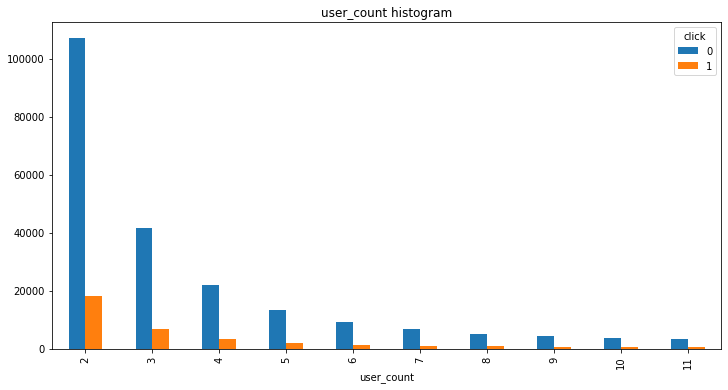

In [0]:
user_count_2_11 = data[(data.user_count.isin((data.user_count.value_counts()/len(data))[1:11].index))]
user_count_2_11.groupby(['user_count', 'click']).size().unstack().plot(kind='bar', figsize=(12,6), title='user_count histogram');

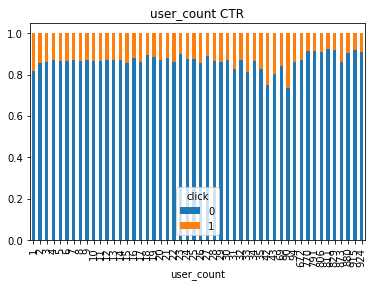

In [0]:
user_count_2_11 = data[(data.user_count.isin((data.user_count.value_counts()/len(data))[0:50].index))]
user_count_2_11 = user_count_2_11.groupby(['user_count','click']).size().unstack()
user_count_2_11.div(user_count_2_11.sum(axis=1), axis=0).plot(kind='bar', stacked=True, title="user_count CTR");

In [0]:
print(data.smooth_user_hour_count.value_counts()/len(data))

1      0.867980
2      0.076440
3      0.019848
4      0.009304
5      0.005635
6      0.004188
7      0.002933
8      0.002504
9      0.001710
10     0.001440
11     0.001375
12     0.000972
13     0.000884
14     0.000616
15     0.000615
16     0.000544
17     0.000391
19     0.000323
20     0.000260
18     0.000252
22     0.000220
21     0.000210
161    0.000161
23     0.000138
24     0.000120
26     0.000104
34     0.000102
25     0.000100
30     0.000090
29     0.000087
27     0.000081
36     0.000072
35     0.000070
28     0.000056
52     0.000052
50     0.000050
42     0.000042
31     0.000031
Name: smooth_user_hour_count, dtype: float64


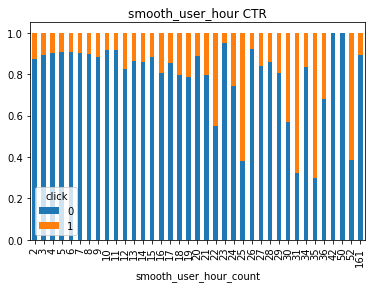

In [0]:
smooth_user_hour_count_2_11 = data[(data.smooth_user_hour_count.isin((data.smooth_user_hour_count.value_counts()/len(data))[1:50].index))]
smooth_user_hour_count_2_11 = smooth_user_hour_count_2_11.groupby(['smooth_user_hour_count','click']).size().unstack()
smooth_user_hour_count_2_11.div(smooth_user_hour_count_2_11.sum(axis=1), axis=0).plot(kind='bar', stacked=True, title="smooth_user_hour CTR");

In [0]:
print(data.user_click_history.value_counts()/len(data)) # get rid of null

0       0.009718
0000    0.003283
00      0.002720
000     0.001196
1       0.001097
1111    0.000278
01      0.000219
10      0.000202
0001    0.000163
0010    0.000158
1000    0.000154
0100    0.000149
0111    0.000125
1110    0.000124
1011    0.000122
1101    0.000113
0101    0.000090
1010    0.000088
0110    0.000080
0011    0.000076
1001    0.000074
1100    0.000069
11      0.000064
010     0.000063
100     0.000056
001     0.000049
101     0.000025
011     0.000023
111     0.000013
110     0.000009
Name: user_click_history, dtype: float64


In [0]:
data.describe()

,click,C1,C14,C15,C16,C17,C18,C19,C20,C21,device_id_count,device_ip_count,user_count,smooth_user_hour_count
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,0.169455,1004.967897,18839.741826,318.889360,60.098362,2112.435999,1.432945,226.959755,53217.607820,83.351003,762678.638068,138.408203,14.241894,1.400476
std,0.375153,1.095876,4959.775142,21.415965,47.272539,609.377917,1.326403,350.794208,49956.801943,70.242278,351042.355193,586.650360,81.546331,2.694119
min,0.000000,1001.000000,375.000000,120.000000,20.000000,112.000000,0.000000,33.000000,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,1005.000000,16920.000000,320.000000,50.000000,1863.000000,0.000000,35.000000,-1.000000,23.000000,924256.000000,1.000000,1.000000,1.000000
50%,0.000000,1005.000000,20346.000000,320.000000,50.000000,2323.000000,2.000000,39.000000,100049.000000,61.000000,924256.000000,2.000000,1.000000,1.000000
75%,0.000000,1005.000000,21894.000000,320.000000,50.000000,2526.000000,3.000000,171.000000,100094.000000,101.000000,924256.000000,10.000000,2.000000,1.000000
max,1.000000,1012.000000,24043.000000,1024.000000,1024.000000,2757.000000,3.000000,1839.000000,100248.000000,255.000000,924256.000000,5560.000000,924.000000,161.000000


In [0]:
# hash int conversion
def convert_obj_to_int(self):
    
    object_list_columns = self.columns
    object_list_dtypes = self.dtypes
    new_col_suffix = '_int'
    for index in range(0,len(object_list_columns)):
        if object_list_dtypes[index] == object :
            self[object_list_columns[index]+new_col_suffix] = self[object_list_columns[index]].map( lambda  x: hash(x) % 1000000)
            self.drop([object_list_columns[index]],inplace=True,axis=1)
    return self
data = convert_obj_to_int(data)

In [0]:
data.dtypes

click                              int64
hour                      datetime64[ns]
C1                                 int64
C14                                int64
C15                                int64
C16                                int64
C17                                int64
C18                                int64
C19                                int64
C20                                int64
C21                                int64
device_id_count                    int64
device_ip_count                    int64
user_count                         int64
smooth_user_hour_count             int64
user_click_histroy               float64
id_int                             int64
banner_pos_int                     int64
device_id_int                      int64
device_ip_int                      int64
device_model_int                   int64
device_type_int                    int64
device_conn_type_int               int64
hour_of_day_int                    int64
day_of_week_int 

In [0]:
# remove original hour and id from the data
y = data.click
data.drop('hour', axis=1, inplace=True)
data.drop('id_int', axis=1, inplace=True)
data.drop('click', axis=1, inplace=True)

# split train and test dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=666)
print('For train, proportion of label 1: ', len(y_train[y_train == 1])/len(y_train))
print('For test, proportion of label 1: ', len(y_test[y_test == 1])/len(y_test))

For train, proportion of label 1:  0.16947875
For test, proportion of label 1:  0.16936


In [0]:
# evaluation matrics
from sklearn import metrics
def get_metric(clf, X, y_true):
    y_pred = clf.predict(X)
    y_proba = clf.predict_proba(X)

    acc = metrics.accuracy_score(y_true, y_pred)
    p = metrics.precision_score(y_true, y_pred)
    r = metrics.recall_score(y_true, y_pred)
    f1 = metrics.f1_score(y_true, y_pred)
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_proba[:, 1])
    auc = metrics.auc(fpr, tpr)
    return acc, p, r, f1, fpr, tpr, auc

In [0]:
# Build models
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

import lightgbm as lgb
from xgboost import XGBClassifier
lr_model = LogisticRegressionCV(class_weight='balanced', cv=5, max_iter=1000)
rf_model = RandomForestClassifier(class_weight='balanced', n_estimators=100)
gbdt_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.08)
xg_model = XGBClassifier(n_estimators=100,learning_rate=0.08,subsample=0.8,colsample_bytree=0.8,max_depth=5)
lgb_model = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.08)
adb_model = AdaBoostClassifier( n_estimators = 100, random_state = 0)

models = {'LR': lr_model,
          'RF': rf_model,
          'GBDT': gbdt_model,
          'XGBoost': xg_model,
          'LightGBM': lgb_model,
          'AdaBoost': adb_model}

In [0]:

if __name__ == '__main__':
    df_result = pd.DataFrame(columns=('Model', 'dataset', 'Accuracy', 'Precision', 'Recall', 'F1 score', 'AUC'))
    row = 0
    fprs_train = []
    tprs_train = []
    aucs_train = []
    fprs_test = []
    tprs_test = []
    aucs_test = []
    for name, clf in models.items():
        clf.fit(X_train, y_train)
        acc, p, r, f1, fpr_train, tpr_train, auc_train = get_metric(clf, X_train, y_train)
        fprs_train.append(fpr_train)
        tprs_train.append(tpr_train)
        aucs_train.append(auc_train)
        df_result.loc[row] = [name, 'train', acc, p, r, f1, auc_train]
        row += 1

        acc, p, r, f1, fpr_test, tpr_test, auc_test = get_metric(clf, X_test, y_test)
        fprs_test.append(fpr_test)
        tprs_test.append(tpr_test)
        aucs_test.append(auc_test)
        df_result.loc[row] = [name, 'test', acc, p, r, f1, auc_test]
        row += 1

        plt.figure()
        lw = 2
        plt.plot(fpr_train, tpr_train, color='darkorange', lw=lw, label='train (AUC:%0.2f)' % auc_train)
        plt.plot(fpr_test, tpr_test, color='cornflowerblue', lw=lw, label='test (AUC:%0.2f)' % auc_test)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic of '+name)
        plt.legend(loc="lower right")
        plt.savefig(name + '.jpg')
        plt.show()

NameError: ignored

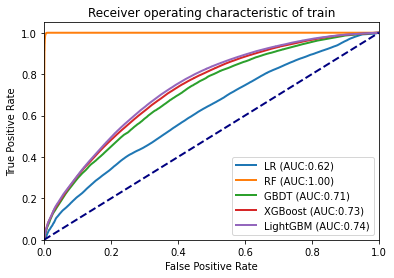

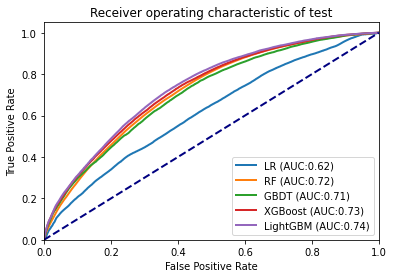

In [0]:
# integrate roc curve into one figure
def plot_roc(fprs, tprs, aucs, title):
    plt.figure()
    lw = 2
    colors = ['deeppink', 'aqua', 'darkorange', 'cornflowerblue', '']
    for i, name in enumerate(models):
        plt.plot(fprs[i], tprs[i], lw=lw,
                 label='{0} (AUC:{1:0.2f})'.format(name, aucs[i]))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic of '+title)
    plt.legend(loc="lower right")
    plt.savefig(title + '.jpg')
    plt.show()

plot_roc(fprs_train, tprs_train, aucs_train, 'train')
plot_roc(fprs_test, tprs_test, aucs_test, 'test')